# Pkg 

In [4]:
##############################################################################
import numpy as np
import pandas as pd
import warnings
import glob

import matplotlib.patches as patches
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse, Circle
from matplotlib import colors

import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy import wcs
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.table import Table
from astropy.wcs import WCS

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import EllipticalAperture

from scipy.optimize import curve_fit

from plotbin.display_pixels import display_pixels


from pkg import ppxf_muse
from pkg import spec_fit
from pkg import photon_ionization_O3fit

##############################################################################
warnings.filterwarnings("ignore")


# Function

In [5]:
### 区分BPT region
def bptregion(x, y, mode='N2'):
    '''
    Args:
        lines: dictionary contains all the needed for bpt
            ['Hb-4862', 'OIII-5008','Ha-6564','NII-6585']
      x: log10(NII/Ha) or log10(SII/Ha) or log10(OI/Ha)
      y: log10(OIII/Hb)
      mode: mode "N2" -> x = log10(NII/Ha)
            mode "S2" -> x = log10(SII/Ha)
            mode "O1" -> x = log10(OI/Ha)  ! not surpport yet
    Note:
      x, y should be masked array, 
      example: x = np.ma.array(x)
    '''
    # check starforming, composite or AGN
    # region = np.zeros_like(lines[0].data)
    from numpy.ma import is_masked
    if mode == 'N2':
        ke01 = 0.61/(x-0.47)+1.19
        ka03 = 0.61/(x-0.05)+1.3
        schawinski_line = 1.05*x+0.45
        region_AGN = np.logical_or(np.logical_and(x<0.47, y>ke01), x>0.47)
        region_composite = np.logical_and(y<ke01, y>ka03)
        region_starforming = np.logical_and(x<0.05, y<ka03)
        # depleted
        #region_seyfert = np.logical_and(x>np.log10(0.6), y>np.log10(3.))
        #region_liner = np.logical_and(region_AGN, np.logical_and(x>np.log10(0.6), y<np.log10(3.)))
        # adapted from Schawinski2007
        region_seyfert = np.logical_and(region_AGN, y>schawinski_line)
        region_liner = np.logical_and(region_AGN, y<schawinski_line)
        if is_masked(x) or is_masked(y):
            return region_AGN.filled(False), region_composite.filled(False), region_starforming.filled(False), region_seyfert.filled(False), region_liner.filled(False)
        else:
            return region_seyfert, region_composite, region_starforming, region_liner

    if mode == 'S2':
        ke01_line = 0.72/(x-0.32)+1.3
        seyfert_liner_line = 1.89*x+0.76
        region_seyfert = np.logical_and(np.logical_or(y>ke01_line, x>0.32), y>seyfert_liner_line)
        region_liner = np.logical_and(np.logical_or(y>ke01_line, x>0.32), y<seyfert_liner_line)
        region_starforming = np.logical_and(y<ke01_line, x<0.32)
        if is_masked(x) or is_masked(y):
            return region_seyfert.filled(False), region_liner.filled(False), region_starforming.filled(False)
        else:
            return region_seyfert, region_liner, region_starforming

# Load Data

In [6]:
##############################################################################
sdssj0228 = fits.open("data/SDSSJ022849.51-090153.8.fits")
spec_data = sdssj0228[1].data
spec_var  = sdssj0228[2].data
header_0228 = sdssj0228[1].header

min_wave  = sdssj0228[0].header['WAVELMIN']*10
max_wave  = sdssj0228[0].header['WAVELMAX']*10
wave_len  = np.linspace(min_wave,max_wave,spec_data.shape[0])
wavelength = wave_len/(1+0.072)

rebin_data_Ha = fits.open('data/SDSSJ0228_rebin_specHa_10.fits')
ppdata = fits.open("data/ppxf/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_wave = ppdata[1].data["wavelength"]

##############################################################################
o3_flux_data = fits.open('data/SDSSJ0228_O3_flux.fits')
o3_velo_data = fits.open('data/SDSSJ0228_O3_5007_kine_results.fits')
Ha_region_data = fits.open('data/SDSSj0228_haregion_flux_rebin.fits')
Hb_region_data = fits.open('data/SDSSj0228_hbregion_flux_rebin.fits')

flux_OIII_narrow = o3_flux_data[2].data
flux_OIII_narrow_err = o3_flux_data[4].data
flux_OIII_broad  = o3_flux_data[6].data
flux_OIII_broad_err = o3_flux_data[8].data

flux_OIII_narrow[np.isnan(flux_OIII_narrow)] = 0
flux_OIII_broad[np.isnan(flux_OIII_broad)] = 0

velo_OIII_broad_50 = o3_velo_data[2].data
velo_OIII_broad_80 = o3_velo_data[6].data

ha_flux = Ha_region_data[1].data
ha_flux_err = Ha_region_data[2].data
n2_flux = Ha_region_data[3].data
n2_flux_err = Ha_region_data[4].data

hb_flux = Hb_region_data[1].data
hb_flux_err = Hb_region_data[2].data

In [7]:
##############################################################################
nx = (np.arange(flux_OIII_narrow.shape[1]) - flux_OIII_narrow.shape[0]/2)/5.
ny = (np.arange(flux_OIII_narrow.shape[0]) - flux_OIII_narrow.shape[1]/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')

ha_snr = ha_flux/ha_flux_err
snr_cut = np.logical_not(ha_snr<10)

# target info

In [11]:
image_wihte = np.nansum(spec_data,axis=0)
wcs1 = WCS(header_0228)
wcs_new = wcs.WCS(naxis=2)
wcs_new.wcs.crpix = [159,156]
wcs_new.wcs.crval = np.array([37.206292,-9.03161])
wcs_new.wcs.cdelt = np.array([-5.55555555555556e-05, 5.55555555555556e-05]) #minus for left-east
wcs_new.wcs.ctype = ['RA---TAN', 'DEC--TAN']
wcs_new.pixel_to_world(142+25,162+25)


<SkyCoord (ICRS): (ra, dec) in deg
    (37.20578573, -9.02983222)>

In [26]:
NII_xs = np.log10(n2_flux/ha_flux)
bpt_ys = np.log10(flux_OIII_narrow/hb_flux)

NII_x = NII_xs[snr_cut]
bpt_y = bpt_ys[snr_cut]

Sey, CP, SF, LINER  = bptregion(NII_xs, bpt_ys, mode='N2')
x_type = np.full_like(xpos, np.nan)
y_type = np.full_like(xpos, np.nan)
x_type[snr_cut] = NII_xs[snr_cut]
y_type[snr_cut] = bpt_ys[snr_cut]

[Text(1, 1.0, 'SF'),
 Text(1, 2.0, 'Comp'),
 Text(1, 3.0, 'Seyfert'),
 Text(1, 4.0, 'LINER')]

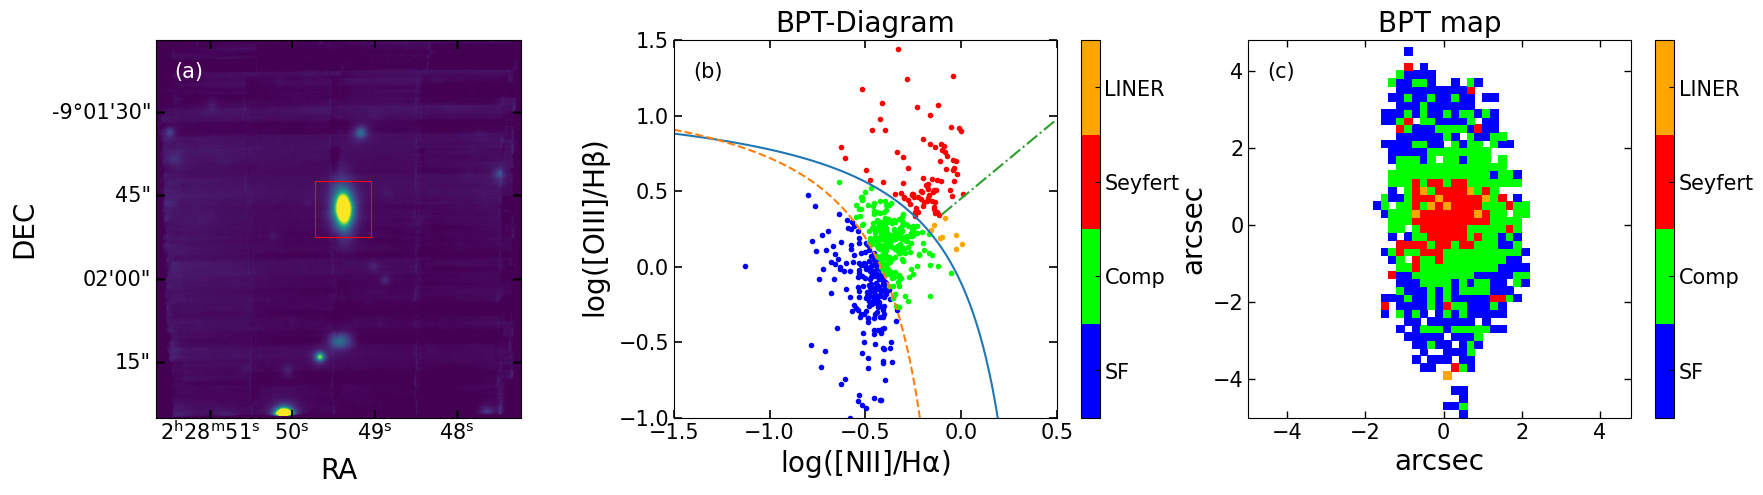

In [31]:
fig = plt.figure(figsize=(21,5),dpi=100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = False
plt.rcParams["ytick.minor.visible"] = False

title_size = 20
ls = 15

ax_whimg = fig.add_subplot(131,projection=wcs_new)

ax_whimg.set_xlabel('RA',fontsize = title_size)
ax_whimg.set_ylabel('DEC',fontsize = title_size)
ax_whimg.tick_params(direction='in', labelsize = ls, length = 6, width=1.2)

ax_whimg.imshow(image_wihte, origin='lower', cmap=plt.cm.viridis,vmin=100,vmax=110000)
rect1 = patches.Rectangle((142, 162),50,50,linewidth=0.8,edgecolor='red',facecolor='none')
ax_whimg.add_patch(rect1)
ax_whimg.text(0.05,0.9,'(a)',transform=ax_whimg.transAxes,fontdict={'size': '15', 'color': 'white'})


ax_bptn   = fig.add_subplot(132)

ax_bptn.set_title('BPT-Diagram',fontsize = title_size)
ax_bptn.set_xlabel(r"$\mathregular{log}(\rm{[NII]/H\alpha})$",fontsize=title_size)
ax_bptn.set_ylabel(r"$\mathregular{log}(\rm{[OIII]/H\beta})$",fontsize=title_size)
ax_bptn.tick_params(direction='in', labelsize = ls, length = 6, width=1.2)
ax_bptn.set_xlim(-1.5,0.5)
ax_bptn.set_ylim(-1.0,1.5)
ax_bptn.text(0.05,0.9,'(b)',transform=ax_bptn.transAxes,fontdict={'size': '15', 'color': 'black'})

ax_bptn.plot(x_type[SF],y_type[SF],'.',color = 'blue')##SF
ax_bptn.plot(x_type[CP],y_type[CP],'.',color = 'lime')##CP
ax_bptn.plot(x_type[Sey],y_type[Sey],'.',color = 'red')##AGN
ax_bptn.plot(x_type[LINER],y_type[LINER],'.',color = 'orange')##AGN

x1 = np.linspace(-1.5, 0.2, 100)
y_ke01 = 0.61/(x1-0.47)+1.19
ax_bptn.plot(x1,y_ke01)
x2 = np.linspace(-1.5, -.2, 100)
y_ka03 = 0.61/(x2-0.05)+1.3
ax_bptn.plot(x2,y_ka03,'--')
x3 = np.linspace(-0.1, 0.5, 100)
y_sch = 1.05*x3+0.45
ax_bptn.plot(x3,y_sch,'-.')


# ax_bptn.legend(('SF','Comp','AGN',
#          'Ke 01','Ka 03'),
#        loc='lower right',fontsize = 10,markerscale = 1)

cb = plt.colorbar(ax_bptm,ticks = np.array([1,2,3,4]))
cb.ax.set_yticklabels(region_name,fontdict={'size': '15', 'color': 'black'})

ax_bptm   = fig.add_subplot(133)

ax_bptm.tick_params(direction='in', labelsize = ls, length = 5, width=1.0)
ax_bptm.set_title(r'BPT map',fontsize=title_size)
ax_bptm.set_xlabel('arcsec',fontsize=title_size)
ax_bptm.set_ylabel('arcsec',fontsize=title_size)
ax_bptm.text(0.05,0.9,'(c)',transform=ax_bptm.transAxes,fontdict={'size': '15', 'color': 'black'})

region_type = np.full_like(xpos, np.nan)
region_color = ['blue','lime','red', 'orange'] 
region_name = ['SF', 'Comp', 'Seyfert', 'LINER']
region_type[LINER] = 4
region_type[Sey] = 3
region_type[CP] = 2
region_type[SF] = 1
new_region = np.full_like(xpos, np.nan)
new_region[snr_cut] = region_type[snr_cut]
bounds = [0.5, 1.5, 2.5, 3.5, 4.5] # set color for imshow
cmap = colors.ListedColormap(region_color)
norm = colors.BoundaryNorm(bounds, cmap.N)
ax_bptm = plt.pcolormesh(xpos, ypos, new_region, cmap=cmap, norm=norm)
cb = plt.colorbar(ax_bptm,ticks = np.array([1,2,3,4]))
cb.ax.set_yticklabels(region_name,fontdict={'size': '15', 'color': 'black'})

# plt.savefig('image/tarinfo_BPTmap.pdf',dpi=600,bbox_inches='tight')

#  spec fitting results

In [ ]:
from os import path
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))
vazdekis = glob.glob(ppxf_dir + '/miles_models/Eun1.30Z*.fits')

In [ ]:
fwhm_dif = np.sqrt((2.42**2 - 2.51**2).clip(0))

In [ ]:
raw_flux = spec_data[:,189,169]
raw_error = np.sqrt(spec_var[:,189,169])
pp_test = ppxf_muse.single_pixel_ppxf_fit(wavelength,raw_flux,raw_error, degree=4,plot=False,formal_error=False)

In [ ]:
##   emission line fitting
y,x =25,25
spec_flux = rebin_data_Ha[1].data[:,y,x]
spec_err = rebin_data_Ha[2].data[:,y,x]
spec_con = rebin_data_Ha[3].data[:,y,x]
STATUS_hb,KINEM_hb = spec_fit.emline_fit(pp_wave,spec_flux,spec_err,spec_con,mode ='Hb', plot=False)
STATUS_ha,KINEM_ha = spec_fit.emline_fit(pp_wave,spec_flux,spec_err,spec_con,mode ='Ha', plot=False)
STATUS_S2,KINEM_S2 = spec_fit.emline_fit(pp_wave,spec_flux,spec_err,spec_con,mode ='S2', plot=False)
STATUS_O3,Kinem_O3 = photon_ionization_O3fit.O3_doublet_fit(pp_wave,spec_flux,spec_err, plot=False, savefig=False)


In [ ]:
# Fig.1
fig = plt.figure(figsize= (15,8))

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

ax_ppxf = plt.axes([.143, .50, .785, .45])
ax_ppxf.set_xticklabels([])
ax_resid = plt.axes([.143,.40,.785,.10])
ax_hb = plt.axes([.143, .07, .22, .25])
ax_ha = plt.axes([.420, .07, .22, .25])
ax_s2 = plt.axes([.720, .07, .22, .25])

####################################################    stellar continuum    ###############################################################
mask_pp = (wavelength > 4800) & (wavelength < 7409)
con_bestfit = pp_test.bestfit*np.median(spec_data[:,188,169][mask_pp])
ax_ppxf.plot(wavelength[mask_pp],spec_data[:,188,169][mask_pp]*10**(-2),'k',lw=0.7,label='observed')
ax_ppxf.plot(wavelength[mask_pp],con_bestfit*10**(-2),'r',lw=2,label='stellar continuum')
# ax_ppxf.plot(wavelength[mask_pp],(spec_data[:,188,169][mask_pp]-con_bestfit)*10**(-2),'gray',lw=0.7,label='continuum-subtracted')
ax_ppxf.text(0.95,0.9,'(a)',transform=ax_ppxf.transAxes,fontdict={'size': '15', 'color': 'black'})

ax_ppxf.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_ppxf.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=15)
ax_ppxf.set_title(r'${\rm spectrum\ fitting\ results\ of\ central\ pixel}$',fontsize=20)
ax_ppxf.set_ylim(0.5,5)
ax_ppxf.set_xlim(4780,7420)

residual_con = (pp_test.galaxy-pp_test.bestfit)*np.median(spec_data[:,188,169][mask_pp])
ax_resid.plot(wavelength[mask_pp][pp_test.goodpixels],residual_con[pp_test.goodpixels]*10**(-2),'g.',label='residual')
ax_resid.plot([4780,7420],[0,0],color = "black",linewidth=2)
ax_resid.set_xlim(4780,7420)
ax_resid.set_ylim(-0.5,0.5)
ax_resid.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_resid.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_resid.set_ylabel(r'${\rm Residual}$',fontsize=15)
ax_ppxf.legend(loc='upper left',fontsize = 15.0,markerscale = 2)

################################################    Hb 4861 [OIII] 4959,5007    ############################################################
maskhb  = (pp_wave > 4830) & (pp_wave < 5030)
mask_HB = (pp_wave > 4830) & (pp_wave < 4941)
mask_Hb = (pp_wave > 4830) & (pp_wave < 4890)
fithb_wave = pp_wave[mask_Hb]
fitHB_wave = pp_wave[mask_HB]
fithb_spec = spec_flux[mask_HB]
popt_hb = np.array(list(STATUS_hb['Hb[4861]_para'])+list(STATUS_hb['Hb[4861]_broad_para']))
fakehb_x = np.arange(fitHB_wave[0], fitHB_wave[-1], 0.01)
ax_hb.text(0.91,0.9,'(b)',transform=ax_hb.transAxes,fontdict={'size': '15', 'color': 'black'})

ax_hb.plot(pp_wave[maskhb], spec_flux[maskhb] * 10 ** (-2), color='k', lw=0.7, alpha=1, label='observed')
ax_hb.plot(fitHB_wave, spec_fit.gaussian(fitHB_wave, *popt_hb) * 10 ** (-2), color='darkorange', lw=2, label='best-fit')
ax_hb.plot(fakehb_x, spec_fit.gaussian(fakehb_x, *popt_hb[0:3]) * 10 ** (-2),'-.', color='C0', label='narrow-part')
try:
    ax_hb.plot(fakehb_x, spec_fit.gaussian(fakehb_x, *popt_hb[3:6]) * 10 ** (-2),'--', label='broad-part', color='magenta')
except:
    pass

mask_OIII = ((pp_wave > 4940) & (pp_wave < 5030))
fitOIII_wave = pp_wave[mask_OIII]
poptOIII = np.array(STATUS_O3['fit_parameter'])
fakeO3_x = np.arange(4940,5030,0.01)

ax_hb.plot(fitOIII_wave,photon_ionization_O3fit.gauss_doublet(fitOIII_wave,*poptOIII)*10**(-2),color='darkorange',lw=2)
ax_hb.plot(fakeO3_x,photon_ionization_O3fit.gauss_doublet(fakeO3_x,*poptOIII[0:4])*10**(-2),'-.',color='C0',lw=1)
try:
    ax_hb.plot(fakeO3_x,photon_ionization_O3fit.gauss_doublet(fakeO3_x,*poptOIII[4:8])*10**(-2),'--',color='magenta',lw=1)
except:
    pass

ax_hb.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_hb.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax_hb.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=13)
ax_hb.set_xlim(4840,5025)
ax_hb.legend(loc='upper left')

################################################    Ha 6563 [NII] 6548,6583    ############################################################

mask_Ha = ((pp_wave > 6530) & (pp_wave < 6610))
fitha_wave = pp_wave[mask_Ha]
fitha_spec = spec_flux[mask_Ha]
popt_ha = np.array(list(STATUS_ha['NII[6548]_para'])+list(STATUS_ha['Ha[6563]_para'])+
                   list(STATUS_ha['NII[6583]_para'])+list(STATUS_ha['Ha[6563]_broad_para']))
fakeha_x = np.arange(fitha_wave[0], fitha_wave[-1], 0.01)
ax_ha.text(0.9,0.9,'(c)',transform=ax_ha.transAxes,fontdict={'size': '15', 'color': 'black'})

ax_ha.plot(fitha_wave, fitha_spec * 10 ** (-2), color='k', lw=0.7, alpha=1,)
ax_ha.plot(fitha_wave, spec_fit.gaussian(fitha_wave, *popt_ha) * 10 ** (-2), color='darkorange', lw=2,)
ax_ha.plot(fakeha_x, spec_fit.gaussian(fakeha_x, *popt_ha[0:9]) * 10 ** (-2),'-.', color='C0',)
try:
    ax_ha.plot(fakeha_x, spec_fit.gaussian(fakeha_x, *popt_ha[9:12]) * 10 ** (-2),'--', color='magenta')
except:
    pass

ax_ha.set_xlim(6530,6600)
ax_ha.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_ha.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax_ha.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=13)

#######################################################    [SII] 6717,6731    ############################################################

mask_SII = ((pp_wave > 6700) & (pp_wave < 6750))
fits2_wave = pp_wave[mask_SII]
fits2_spec = spec_flux[mask_SII]
popt_s2 = np.array(list(STATUS_S2['SII[6717]_para'])+list(STATUS_S2['SII[6731]_para']))
fakes2_x = np.arange(fits2_wave[0], fits2_wave[-1], 0.01)
ax_s2.text(0.9,0.9,'(d)',transform=ax_s2.transAxes,fontdict={'size': '15', 'color': 'black'})

ax_s2.plot(fits2_wave, fits2_spec * 10 ** (-2), color='k', lw=0.7, alpha=1,)
ax_s2.plot(fits2_wave, spec_fit.gaussian(fits2_wave, *popt_s2) * 10 ** (-2), color='darkorange', lw=2,)
ax_s2.plot(fakes2_x, spec_fit.gaussian(fakes2_x, *popt_s2) * 10 ** (-2),'-.', color='C0',)

ax_s2.set_xlim(6700,6747)
# ax_s2.set_ylim(-0.2,0.6)
ax_s2.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax_s2.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_s2.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=13)

plt.tight_layout()
# plt.savefig('image/spectrum_fit_results.pdf',dpi = 600,bbox_inches='tight')

#  photometry result


In [10]:
frame_r = fits.open('data/photometry/frame-r-006572-2-0145.fits')
SD_star = ascii.read("data/Sigma_star_10kpc.txt")
SD_gas  = ascii.read("data/gasmass_surface_density_2model.txt")
SD_sfr  = ascii.read("data/Sigma_SFR_2model.txt")

radius  = SD_gas["R"]
SD_bulge = SD_star["density_bulge"][0:-2]
SD_bulge_err = SD_star["density_bulge_error"][0:-2]
SD_disc = SD_star["density_disc"][0:-2]
SD_disc_err = SD_star["density_disc_error"][0:-2]
SD_gasep = SD_gas["SD_GAS_ep"]
SD_gasep_err = SD_gas["SD_GAS_ep_err"]
SD_gasdisk = SD_gas["SD_GAS_disk"]
SD_gasdisk_err = SD_gas["SD_GAS_disk_err"]

SD_sfr_disk = SD_sfr["SFR_dendity_disc"]
SD_sfr_disk_err = SD_sfr["SFR_dendity_disc_err"]
SD_sfr_ex = SD_sfr["SFR_dendity_ep"]
SD_sfr_ex_err = SD_sfr["SFR_dendity_ep_err"]

In [7]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

a, b, c = 0.00997753, 0.29870517, -0.00048096

In [8]:
from astropy import wcs
wcs_new = wcs.WCS(naxis=2)
wcs_new.wcs.crpix = [25,25]
wcs_new.wcs.crval = np.array([37.20578573, -9.02983222])
wcs_new.wcs.cdelt = np.array([-5.55555555555556e-05, 5.55555555555556e-05]) #minus for left-east
wcs_new.wcs.ctype = ['RA---TAN', 'DEC--TAN']

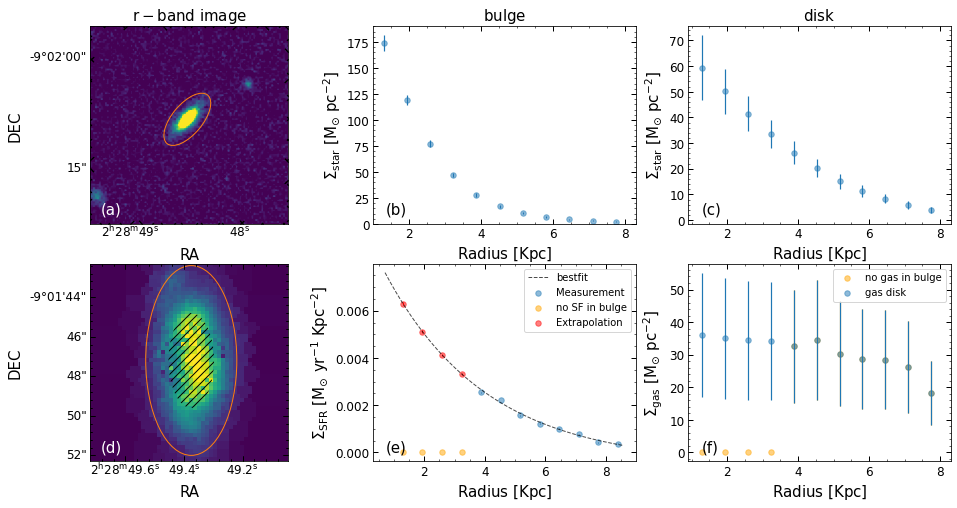

In [10]:
# Fig.2 
fig = plt.figure(figsize=(16,8))
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

fr_data = frame_r[0].data[1111:1136,1787:1812]
test_data = frame_r[0].data
wcs1= wcs.WCS(frame_r[0].header)

ax1 = fig.add_subplot(231, projection=wcs1)
ax1.imshow(test_data,origin='lower',vmin = 0,vmax=0.5)
ax1.text(0.05,0.05,'(a)',transform=ax1.transAxes,fontdict={'size': '15', 'color': 'white'})
ell1 = Ellipse((1799,1123),width = (16)*2, height = (16*0.48)*2, 
                   angle = 50,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)
ax1.add_patch(ell1)
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax1.set_xlabel('RA',fontsize = 15)
ax1.set_ylabel('DEC',fontsize = 15)
plt.title(r"${\rm r-band\ image}$",fontsize = 15)
plt.ylim(1070,1170)
plt.xlim(1750,1850)

ax2 = fig.add_subplot(232)

plt.errorbar(radius,SD_bulge,yerr = SD_bulge_err,color='C0',linestyle='None',elinewidth=1.2,ms=6,capsize=0) 
plt.scatter (radius,SD_bulge,c='C0', marker='o',s= 30, alpha = 0.5) 
ax2.text(0.05,0.05,'(b)',transform=ax2.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.xlim(1.0,8.3)
plt.ylim(0,190)
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
plt.title(r'${\rm bulge}$',fontsize=15)
plt.ylabel(r'${\rm \Sigma_{star} \ [M_{\odot} \ pc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=15)

ax3 = fig.add_subplot(233)

plt.errorbar(radius,SD_disc,yerr = SD_disc_err,color='C0',linestyle='None',elinewidth=1.2,ms=6,capsize=0)    ###   brightness profile
plt.scatter (radius,SD_disc,c='C0', marker='o',s= 30, alpha = 0.5) 

ax3.text(0.05,0.05,'(c)',transform=ax3.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
plt.title(r'${\rm disk}$',fontsize=15)
plt.ylabel(r'${\rm \Sigma_{star} \ [M_{\odot} \ pc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=15)
plt.xlim(0.9,8.3)

ax4 = fig.add_subplot(234, projection=wcs_new)

ax4.imshow(ha_flux,vmin = 10,vmax = 800,origin='lower')
ellha = Ellipse((25,25),width = (24)*2, height = (24*0.48)*2, 
                   angle = 90,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)

ax4.add_patch(ellha)
ax4.text(0.05,0.05,'(d)',transform=ax4.transAxes,fontdict={'size': '15', 'color': 'white'})

Zm = Ellipse((25,25),width = (12)*2, height = (12*0.48)*2, 
                   angle = 90,linestyle = '-',edgecolor = 'k',fc = 'none',lw = 0,hatch='///')
ax4.add_patch(Zm)
# ax4.pcolor(Zm, hatch='/', edgecolor='grey',facecolor='none', linewidth=0)

plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax4.set_xlabel('RA',fontsize = 15)
ax4.set_ylabel('DEC',fontsize = 15)

ax5 = fig.add_subplot(235)

fakex = np.arange(0.7,8.6,0.01)
fakey = [func(i, a, b, c) for i in fakex]
ax5.plot(fakex,fakey,'k--',lw = 1.0, alpha = 0.7, label= "bestfit")

ax5.errorbar(radius[4:],SD_sfr_disk[4:],yerr = SD_sfr_disk_err[4:],color='C0',linestyle='None',elinewidth=1.2,ms=6,capsize=0)
ax5.scatter (radius[4:],SD_sfr_disk[4:],c='C0', marker='o',s= 30, alpha = 0.5,label="Measurement") 

ax5.errorbar(radius[0:4],SD_sfr_disk[0:4],yerr = SD_sfr_disk_err[0:4],color='orange',linestyle='None',elinewidth=1.2,ms=6,capsize=0)
ax5.scatter (radius[0:4],SD_sfr_disk[0:4],c='orange', marker='o',s= 30, alpha = 0.5,label="no SF in bulge") 

ax5.errorbar(radius[0:4],SD_sfr_ex[0:4],yerr = SD_sfr_ex_err[0:4],color='red',linestyle='None',elinewidth=1.2,ms=6,capsize=0)
ax5.scatter(radius[0:4],SD_sfr_ex[0:4],marker='o',s= 30, alpha = 0.5, color='red',label="Extrapolation")

plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax5.text(0.05,0.05,'(e)',transform=ax5.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.ylabel(r'${\rm \Sigma_{SFR} \ [M_{\odot} \ yr^{-1} \ Kpc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=15)
plt.legend()

ax6 = fig.add_subplot(236)

plt.errorbar(radius,SD_gasdisk,yerr=SD_gasdisk_err,color='orange',linestyle='None',elinewidth=1.2,ms=6,capsize=0)
plt.scatter (radius,SD_gasdisk,c='orange', marker='o',s= 30, alpha = 0.5,label="no gas in bulge")

plt.errorbar(radius,SD_gasep,yerr=SD_gasep_err,color='C0',linestyle='None',elinewidth=1.2,ms=6,capsize=0)
plt.scatter (radius,SD_gasep,c='C0', marker='o',s= 30, alpha = 0.5,label="gas disk")

plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax6.text(0.05,0.05,'(f)',transform=ax6.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.ylabel(r'${\rm \Sigma_{gas} \ [M_{\odot} \ pc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=15)
plt.xlim(0.9,8.3)
plt.legend()

plt.savefig("image/photometry_mask.pdf",dpi=600,bbox_inches = 'tight')

#  circular velocity

In [11]:
ha_vmap = fits.open("data/SDSSJ0228_Ha_velocity.fits")
rc_data = ascii.read('data/rotation_curve_error_v2.txt')
v_ha_data = ascii.read('data/Ha_rotataion_velocity.txt')
v_circ_data = ascii.read('data/asymmetric_draft_correction.txt')
SD_gas  = ascii.read("data/gasmass_surface_density_2model.txt")
ha_vm_data = ha_vmap[1].data

radius  = SD_gas["R"]
R_star_mask = np.where(radius<8)
bulge_v = rc_data['rc_bulge_v'][R_star_mask]
bulge_v_err = rc_data['rc_bulge_err'][R_star_mask]
disk_v = rc_data['rc_disk_v'][R_star_mask]
disk_v_err = rc_data['rc_disk_err'][R_star_mask]
gasep_v = rc_data['rc_gasep_v'][R_star_mask]
gasep_v_err = rc_data['rc_gasep_err'][R_star_mask] 
gasdisk_v = rc_data['rc_gasdisk_v'][R_star_mask]
gasdisk_v_err = rc_data['rc_gasdisk_err'][R_star_mask] 

star_v = np.sqrt(bulge_v**2 + disk_v**2)
star_v_err = np.sqrt((bulge_v_err*bulge_v/star_v)**2+(disk_v_err*disk_v/star_v)**2)

# baron_v = np.sqrt(star_v**2 + gas_v**2)
# baron_v_err = np.sqrt((star_v_err*star_v/baron_v)**2+(gas_v_err*gas_v/baron_v)**2)

r_circ = v_circ_data["R"]
v_circ = v_circ_data["v_circ"]
v_circ_err = v_circ_data["v_circ_err"]
v_p = v_circ_data["v_p"]
v_p_err = v_circ_data["v_p_err"]

dist = 335.8     
snr_x = np.arange(-25,25,1)
snr_mask = np.where(np.abs(snr_x)<19)
kpc_perpix = (0.2/2.06e5)*dist*1.0e3
radius_ = np.array(v_ha_data['R(kpc)'])[snr_mask]*(kpc_perpix/0.3) 
radii = radius_[0:radius_.shape[0]:2]
v_ha = np.array(v_ha_data['v_Ha_ro'])[snr_mask]
Ha_v = v_ha[0:v_ha.shape[0]:2]
v_ha_err = np.array(v_ha_data['v_Ha_ro_error'])[snr_mask]
Ha_v_err = v_ha_err[0:v_ha_err.shape[0]:2]


In [216]:
## plot the NFW profile
M_sun = 1
M_halo = 10**11.87 * M_sun
R_200 = 192.08
R_200_err = 11.97
H0_h = 0.674
c_200 = 10.10
V_200 = R_200 * H0_h
V_200_err = R_200_err * H0_h
# V_200,V_200_err

In [235]:
r = np.arange(0,200,0.1)
# r = radius[R_star_mask]
V_halo_frac = np.sqrt((np.log(1 + c_200 * (r/R_200)) - (c_200*(r/R_200))/(1 + c_200*(r/R_200))) / 
                         ((r/R_200) * (np.log(1+c_200) - c_200/(1+c_200))))
v_halo = V_200 * V_halo_frac
v_halo_err = V_200_err * V_halo_frac

In [255]:
# v_total = np.sqrt(star_v**2 + gasep_v**2 + v_halo**2)
# v_total_err = np.sqrt((star_v_err*star_v/v_total)**2 + \
#                       (gasep_v_err*gasep_v/v_total)**2 + \
#                       (v_halo_err*v_halo/v_total))

v_circ_s = v_circ[::2]
v_circ_serr = v_circ_err[::2]
v_halo_m = np.sqrt(v_circ_s**2 - star_v**2 - gasep_v**2)
v_halo_m_err = np.sqrt((star_v_err*star_v/v_halo_m)**2 + \
                      (gasep_v_err*gasep_v/v_halo_m)**2 + \
                      (v_circ_serr*v_circ_s/v_halo_m))


(-20.0, 180.0)

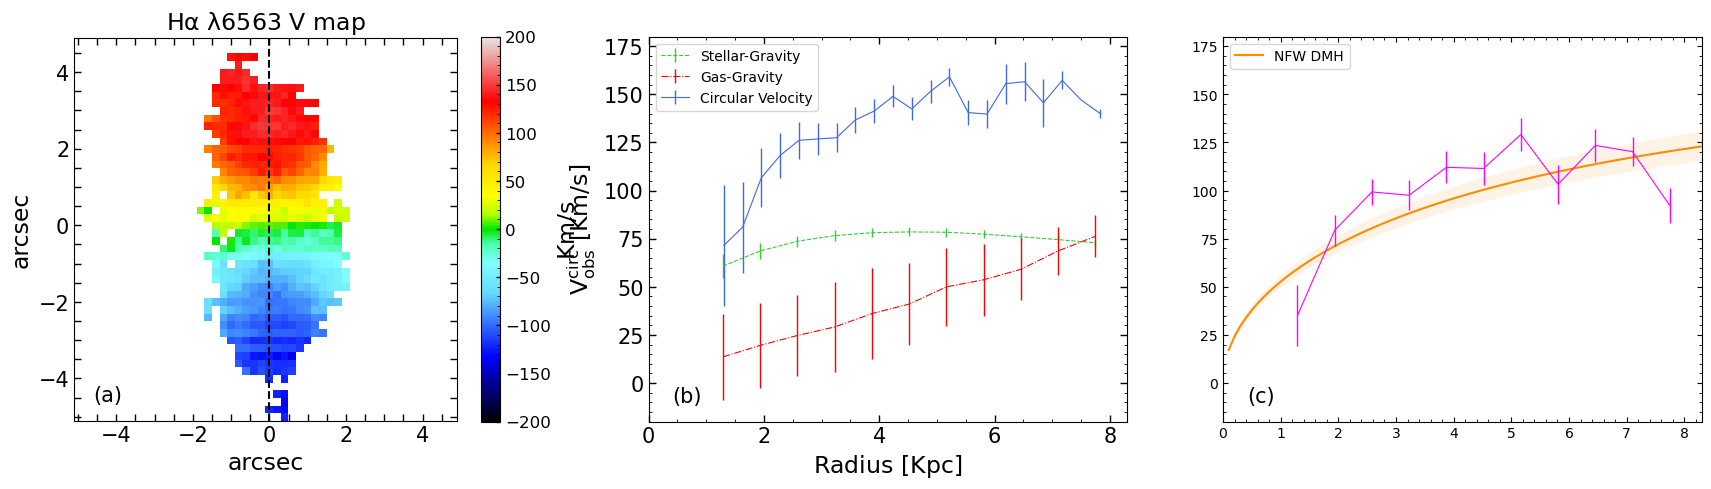

In [261]:
# Fig.3
plt.figure(figsize=(21,5),dpi = 100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

ax_vmap = plt.subplot(131)

ax_vmap.text(0.05,0.05,'(a)',transform=ax_vmap.transAxes,fontdict={'size': '15', 'color': 'black'})

velo_hanb_v2 = ha_vm_data - np.median(ha_vm_data)

Ha_vel = np.full_like(velo_hanb_v2,np.nan)
Ha_vel[snr_cut] = velo_hanb_v2[snr_cut]
ax_vmap = display_pixels(xpos, ypos, Ha_vel,vmin=-200,vmax=200)
plt.axvline(0,color='k',linestyle="--")
cb = plt.colorbar(ax_vmap)
cb.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)
cb.set_label(r'${\rm Km/s}$',fontsize = 17)
plt.title(r'${\rm H\alpha\ \lambda 6563\ V\ map}$',fontsize = 17)
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.xlabel('arcsec',fontsize = 17)
plt.ylabel('arcsec',fontsize = 17)


ax_rc = plt.subplot(132)

ax_rc.text(0.05,0.05,'(b)',transform=ax_rc.transAxes,fontdict={'size': '15', 'color': 'black'})

plt.errorbar(radius[R_star_mask],star_v,yerr=star_v_err,color='limegreen',fmt='--',lw=0.8,elinewidth=1,ms=6,capsize=0,  label = 'Stellar-Gravity')

plt.errorbar(radius[R_star_mask],gasep_v,yerr=gasep_v_err,color='red',fmt='-.',lw=0.8,elinewidth=1,ms=6,capsize=0, label = 'Gas-Gravity')

plt.errorbar(r_circ,v_circ,yerr=v_circ_err,color='royalblue',fmt='-',lw=0.8, elinewidth=1,ms=7,capsize=0, label='Circular Velocity')


plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm V^{circ}_{obs}\ [Km/s]}$',fontsize=17)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=17)
plt.legend(fontsize = 10.0,markerscale = 1.3,  loc = 'upper left')
plt.xlim(0,8.3)
plt.ylim(-20,180)

ax_halo = plt.subplot(133)

ax_halo.text(0.05,0.05,'(c)',transform=ax_halo.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.plot(r, v_halo,c= "darkorange",label='NFW DMH')
plt.fill_between(r, v_halo + v_halo_err, v_halo - v_halo_err,\
             color='darkorange', alpha=0.1, edgecolors='none')

plt.errorbar(radius[R_star_mask],v_halo_m,yerr=v_halo_m_err,color='magenta',fmt='-',lw=0.8, elinewidth=1,ms=7,capsize=0,)

plt.legend(fontsize = 10.0,markerscale = 1.3, loc = 'upper left')
plt.xlim(0,8.3)
plt.ylim(-20,180)

# plt.savefig('image/vel-map-and-rc.pdf',dpi=600,bbox_inches='tight')

#  spatial resolved properties

In [15]:
##############################################################################
flux_O3_t = (flux_OIII_narrow + flux_OIII_broad) *10**(0.40-3)

##############################################################################

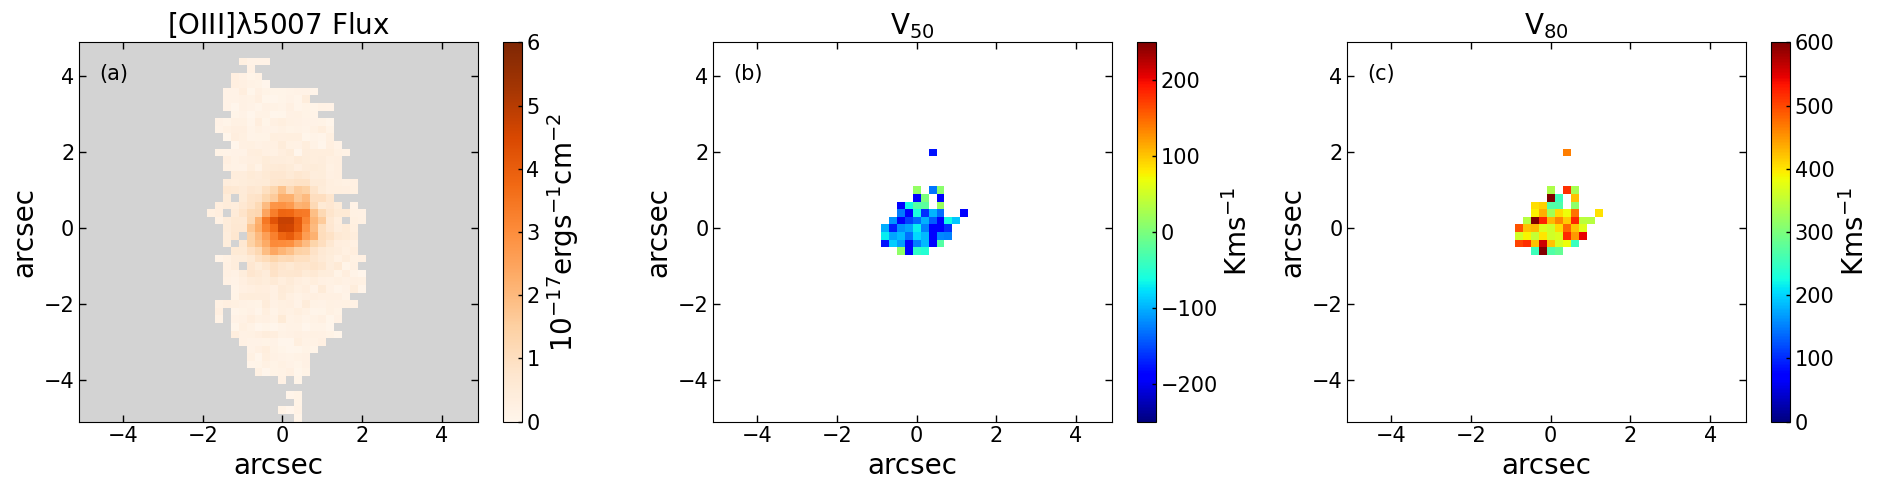

In [40]:
# Fig: Spatially-resolved properties
fig = plt.figure(figsize=(19,5),dpi=100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = False
plt.rcParams["ytick.minor.visible"] = False

title_size = 20
ls = 15

ax_O3f    = fig.add_subplot(131)

ax_O3f.set_facecolor('lightgray')

ax_O3f.set_title(r'${\rm [OIII] \lambda 5007\ Flux}$',fontsize = title_size)
ax_O3f.text(0.05,0.9,'(a)',transform=ax_O3f.transAxes,fontdict={'size': '15', 'color': 'black'})
ax_O3f.tick_params(direction='in', labelsize = ls, length = 5, width=1.0)
ax_O3f.set_xlabel('arcsec',fontsize=title_size)
ax_O3f.set_ylabel('arcsec',fontsize=title_size)

cir1 = Circle(xy = (0.1, 0.1), radius=0.2*3.5, linestyle = '-',edgecolor = 'r',fc = 'none',lw = 1.5)
ax_O3f.add_patch(cir1)

flux_o3n = np.full_like(flux_O3_t,np.nan)
flux_o3n[snr_cut] = flux_O3_t[snr_cut]
ax_O3f = plt.pcolormesh(xpos, ypos, flux_o3n,vmin=0,vmax=6,cmap='Oranges')
cb = plt.colorbar(ax_O3f)
cb.ax.tick_params(direction='in', labelsize = ls, length = 3, width=1.0)
cb.set_label(r'${\rm 10^{-17}ergs^{-1}cm^{-2}}$',fontsize = title_size)

ax_outlv = fig.add_subplot(132)

ax_outlv.set_title(r'${\rm V_{50}}$',fontsize = title_size)
ax_outlv.set_xlabel('arcsec',fontsize = title_size)
ax_outlv.set_ylabel('arcsec',fontsize = title_size)
ax_outlv.tick_params(direction='in', labelsize = ls, length = 5, width=1.0)
ax_outlv.text(0.05,0.9,'(b)',transform=ax_outlv.transAxes,fontdict={'size': '15', 'color': 'black'})
o3_v50 = np.full_like(velo_OIII_broad_50,np.nan)
o3_v50[snr_cut] = velo_OIII_broad_50[snr_cut]
o3_v50[19,24] = np.nan

ax_outlv = plt.pcolormesh(xpos, ypos, o3_v50,vmin=-250,vmax=250,cmap='jet')

cb = plt.colorbar(ax_outlv)
cb.ax.tick_params(direction='in', labelsize = ls, length = 3, width=1.0)
cb.set_label(r'${\rm Kms^{-1}}$',fontsize = title_size)

ax_outv  = fig.add_subplot(133)

ax_outv.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_outv.set_title(r'${\rm V_{80}}$',fontsize = title_size)
ax_outv.set_xlabel('arcsec',fontsize = title_size)
ax_outv.set_ylabel('arcsec',fontsize = title_size)
ax_outv.text(0.05,0.9,'(c)',transform=ax_outv.transAxes,fontdict={'size': '15', 'color': 'black'})

o3_v80 = np.full_like(velo_OIII_broad_80,np.nan)
o3_v80[snr_cut] = velo_OIII_broad_80[snr_cut]
o3_v80[19,24] = np.nan
ax_outv = plt.pcolormesh(xpos, ypos, o3_v80,vmin=0,vmax=600,cmap='jet')

cb = plt.colorbar(ax_outv)
cb.ax.tick_params(direction='in', labelsize = ls, length = 3, width=1.0)
cb.set_label(r'${\rm Kms^{-1}}$',fontsize = title_size)

plt.tight_layout()
# plt.savefig('image/spatial_resolved_image.pdf',dpi=600, bbox_inches='tight')

In [80]:
O3_V80_mock = np.full_like(o3_v80,0)
O3_V80_mock[snr_cut] = o3_v80[snr_cut]
O3_V80_mock[np.isnan(O3_V80_mock)] = 0
y24_V80 = O3_V80_mock[24,:]
y25_V80 = O3_V80_mock[25,:]
y26_V80 = O3_V80_mock[26,:]
minor_V80_0 = y24_V80+y25_V80+y26_V80
minor_V80_1 = minor_V80_0/3
minor_V80_1[21] = 426.83611504757675 
minor_V80_1[30] = 343.7475253357736

O3_V50_mock = np.full_like(o3_v50,0)
O3_V50_mock[snr_cut] = o3_v50[snr_cut]
O3_V50_mock[np.isnan(O3_V50_mock)] = 0
y25_V50 = O3_V50_mock[25,:]
y25_V50[30] = -151.1241327

# V_out vs. V_circ

In [81]:
v_O3_data = ascii.read('data/OIII_outflow_velocity.txt')

half_gn0 = np.logical_not(radius_<0)
half_ln0 = np.where(radius_<0)
v_ha_gn0_log = np.log10(np.abs(v_ha[half_gn0]))
v_ha_ln0_log = -np.log10(np.abs(v_ha[half_ln0]))
v_ha_log_v1 = [v_ha_ln0_log,v_ha_gn0_log]
v_ha_log = [y for x in v_ha_log_v1 for y in x]
v_ha_err_log = np.sqrt(v_ha_err**2/v_ha**2)/(np.log(10))

log_v_circ = np.log10(v_circ)
log_v_circ_err = np.sqrt(v_circ_err**2/v_circ**2)/(np.log(10))

radius_O3 = v_O3_data['R(kpc)']
v50_O3 = y25_V50
v50_O3_err = v_O3_data['v50_O3_broad_error']
v50_O3_log = -np.log10(np.abs(v50_O3))
v50_O3_err_log = np.sqrt(v50_O3_err**2/v50_O3**2)/(np.log(10))
v80_O3 = minor_V80_1
v80_O3_err = v_O3_data['v80_O3_broad_error']
v80_O3_log = np.log10(np.abs(v80_O3))
v80_O3_err_log = np.sqrt(v80_O3_err**2/v80_O3**2)/(np.log(10))

# star_v_log = np.log10(star_v)
# star_v_err_log = np.sqrt(star_v_err**2/star_v**2)/(np.log(10))
# bar_v_log = np.log10(baron_v)
# bar_v_err_log = np.sqrt(baron_v_err**2/baron_v**2)/(np.log(10))
# gas_v_log = np.log10(np.abs(gas_v))
# gas_v_err_log = np.sqrt(gas_v_err**2/gas_v**2)/(np.log(10))

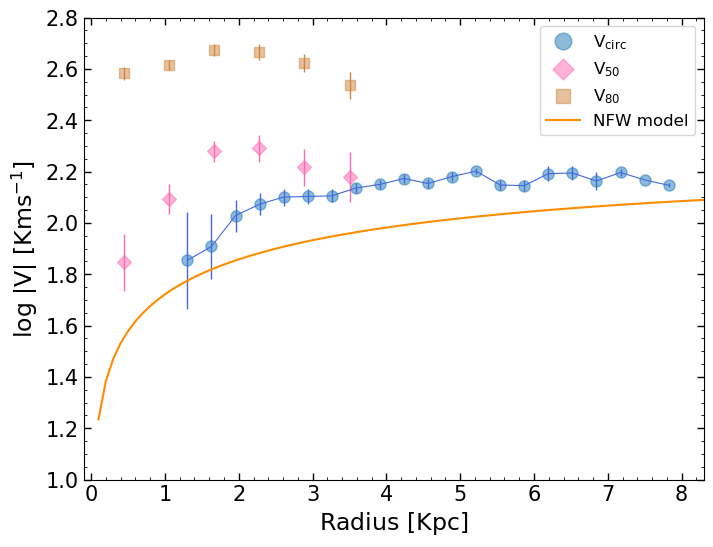

In [213]:
plt.figure(figsize=(8,6),dpi = 100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.plot(r_circ,log_v_circ,c='C0',marker='o',ms=8,linestyle="None",alpha=0.5,label=r'${\rm V_{circ}}$')
plt.errorbar(r_circ,log_v_circ,yerr = log_v_circ_err,
             ms=9, fmt = '-',color = 'royalblue',lw = 0.8, capsize=0,elinewidth=1)

plt.errorbar(radius_O3+0.44,np.abs(v50_O3_log),yerr=v50_O3_err_log,color = 'hotpink',linestyle="None", elinewidth=1,ms=6,capsize=0)
plt.scatter(radius_O3+0.44,np.abs(v50_O3_log), c='hotpink', marker='D',s= 50, alpha = 0.5, label= r'${\rm V_{50}}$')
plt.errorbar(radius_O3+0.44,np.abs(v80_O3_log),yerr=v80_O3_err_log,color = 'peru',linestyle="None",elinewidth=1,ms=8,capsize=0)
plt.scatter(radius_O3+0.44,np.abs(v80_O3_log), c='peru', marker='s',s= 50, alpha = 0.5, label= r'${\rm V_{80}}$')

plt.plot(r, np.log10(v_halo),c= "darkorange",label='NFW model')
plt.fill_between(r, v_halo + v_halo_err/v_halo/np.log(10), v_halo - v_halo_err/v_halo/np.log(10),\
             color='darkorange', alpha=0.8, edgecolors='none')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm log\ |V|\ [Kms^{-1}]}$',fontsize=17)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=17)
# plt.title(r'outflow velocity vs. circular velocity ',fontsize=20)
plt.legend(fontsize = 12.0,markerscale = 1.5)
plt.xlim(-1e-1,8.3)
plt.ylim(1, 2.8)
plt.savefig("image/outflow vs rotation-curve_log.pdf",dpi=600,bbox_inches = 'tight')

# Ne

In [91]:
Ne_data = ascii.read("data/log_ne_major_axis.txt")
R_ne = Ne_data["Radius"]
log_ne = Ne_data["log_Ne"]
log_ne_err = Ne_data["log_Ne_err"]

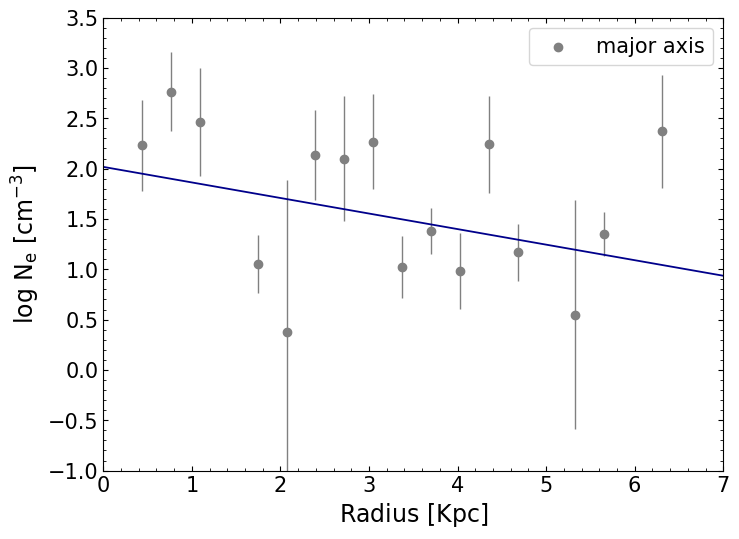

In [290]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel(r"${\rm  Radius\ [Kpc]}$", fontsize=17)
ax.set_ylabel(r"${\rm log\ N_{e}\ [cm^{-3}]}$", fontsize=17)

ax.errorbar(R_ne,log_ne,yerr = log_ne_err,color = 'gray',fmt='o:',elinewidth=1,ms=5,capsize=0,linestyle='None')
ax.scatter(R_ne,log_ne,label='major axis',color = 'gray')
fx = np.arange(0,10,0.0001)
fy = -0.15448187 * fx + 2.01691284
ax.plot(fx,fy,'darkblue', alpha=1,lw=1.3)
ax.set_xlim(0, 7)
ax.set_ylim(-1, 3.5)
plt.legend(fontsize=15.0, markerscale=1)

plt.savefig('image/N_e_R.pdf',dpi = 600, bbox_inches='tight')

#  F_esc vs. L_AGN & M_BH

In [88]:
Liu2020_info

tar_name,W80_ave,vout_ave,W80_max,vout_max,vesc,vesc_err,log_mstar,log_mbh,log_LO3,log_LAGN,f_W80_med,f_W80_med_err,f_vout_med,f_vout_med_err,f_W80_max,f_W80_max_err,f_vout_max,f_vout_max_err
str10,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0842+0319,500,360.0,750,535.0,299,173.42,9.34,5.84,40.51,42.66228834438306,1.6722408026755853,0.70178344238091,1.2040133779264215,0.7158910531638176,2.508361204013378,0.7071067811865475,1.7892976588628762,0.7280109889280517
J0906+5610,980,560.0,1250,775.0,303,175.73999999999998,9.36,5.4,41.15,43.30228834438306,3.2343234323432344,0.70178344238091,1.8481848184818481,0.7158910531638176,4.125412541254126,0.7071067811865475,2.557755775577558,0.7280109889280517
J0954+4717,730,425.0,1100,630.0,317,183.85999999999999,9.12,4.9,41.36,43.51228834438306,2.302839116719243,0.70178344238091,1.3406940063091484,0.7158910531638176,3.470031545741325,0.7071067811865475,1.9873817034700316,0.7280109889280517
J1005+1257,730,505.0,1200,800.0,385,223.29999999999998,9.97,4.8,40.2,42.35228834438306,1.896103896103896,0.70178344238091,1.3116883116883118,0.7158910531638176,3.116883116883117,0.7071067811865475,2.0779220779220777,0.7280109889280517
J1009+2656,210,125.0,480,300.0,241,139.78,8.77,5.1,40.48,42.632288344383056,0.8713692946058091,0.70178344238091,0.5186721991701245,0.7158910531638176,1.991701244813278,0.7071067811865475,1.2448132780082988,0.7280109889280517


In [89]:
SDSSJ0228_info = ascii.read("data/target_info_SDSSJ0228.txt")
Liu2020_info   = ascii.read("data/Liu2020_target_info.txt")
McElroy2015_info = ascii.read("data/McElroy2015_target_info.txt")

## SDSSJ0228 
log_Mstar = SDSSJ0228_info[6][1]
log_Mbh = SDSSJ0228_info[7][1]
log_LAGN = SDSSJ0228_info[9][1]
F_W80 = SDSSJ0228_info[12][1]
F_W80_err = SDSSJ0228_info[13][1]
F_V80 = SDSSJ0228_info[14][1]
F_V80_err = SDSSJ0228_info[15][1]
F_W80_max = SDSSJ0228_info[16][1]
F_W80_max_err = SDSSJ0228_info[17][1]
F_V80_max = SDSSJ0228_info[18][1]
F_V80_max_err = SDSSJ0228_info[19][1]

logL_edd = np.log10(1.26) + 38 + log_Mbh
logR_edd = log_LAGN - logL_edd
logMbh_Mstar = log_Mbh - log_Mstar


## Liu 2020
log_Mstar_L20 = Liu2020_info["log_mstar"]
log_Mbh_L20 = Liu2020_info["log_mbh"]
log_LAGN_L20 = Liu2020_info["log_LAGN"]
F_W80_L20 = Liu2020_info["f_W80_med"]
F_W80_err_L20 = Liu2020_info["f_W80_med_err"]
F_V80_L20 = Liu2020_info["f_vout_med"]
F_V80_err_L20 = Liu2020_info["f_vout_med_err"]
F_W80_max_L20 = Liu2020_info["f_W80_max"]
F_W80_max_err_L20 = Liu2020_info["f_W80_max_err"]
F_V80_max_L20 = Liu2020_info["f_vout_max"]
F_V80_max_err_L20 = Liu2020_info["f_vout_max_err"]

logL_edd_L20 = np.log10(1.26) + 38 + log_Mbh_L20
logR_edd_L20 = log_LAGN_L20 - logL_edd_L20
logMbh_Mstar_L20 = log_Mbh_L20 - log_Mstar_L20


## McElroy 2015 
log_Mstar_M15 = McElroy2015_info["log_mstar"]
log_Mbh_M15 = McElroy2015_info["log_mbh"]
log_LAGN_M15 = McElroy2015_info["log_LAGN"]
F_W80_M15 = McElroy2015_info["f_W80_med"]
F_W80_err_M15 = McElroy2015_info["f_W80_med_err"]
F_V80_M15 = McElroy2015_info["f_vout_med"]
F_V80_err_M15 = McElroy2015_info["f_vout_med_err"]
F_W80_max_M15 = McElroy2015_info["f_W80_max"]
F_W80_max_err_M15 = McElroy2015_info["f_W80_max_err"]
F_V80_max_M15 = McElroy2015_info["f_vout_max"]
F_V80_max_err_M15 = McElroy2015_info["f_vout_max_err"]

logL_edd_M15 = np.log10(1.26) + 38 + log_Mbh_M15
logR_edd_M15 = log_LAGN_M15 - logL_edd_M15
logMbh_Mstar_M15 = log_Mbh_M15 - log_Mstar_M15

In [202]:
np.array(10**logR_edd_L20)

array([0.05271301, 0.63374975, 3.25025773, 0.28308561, 0.27034466])

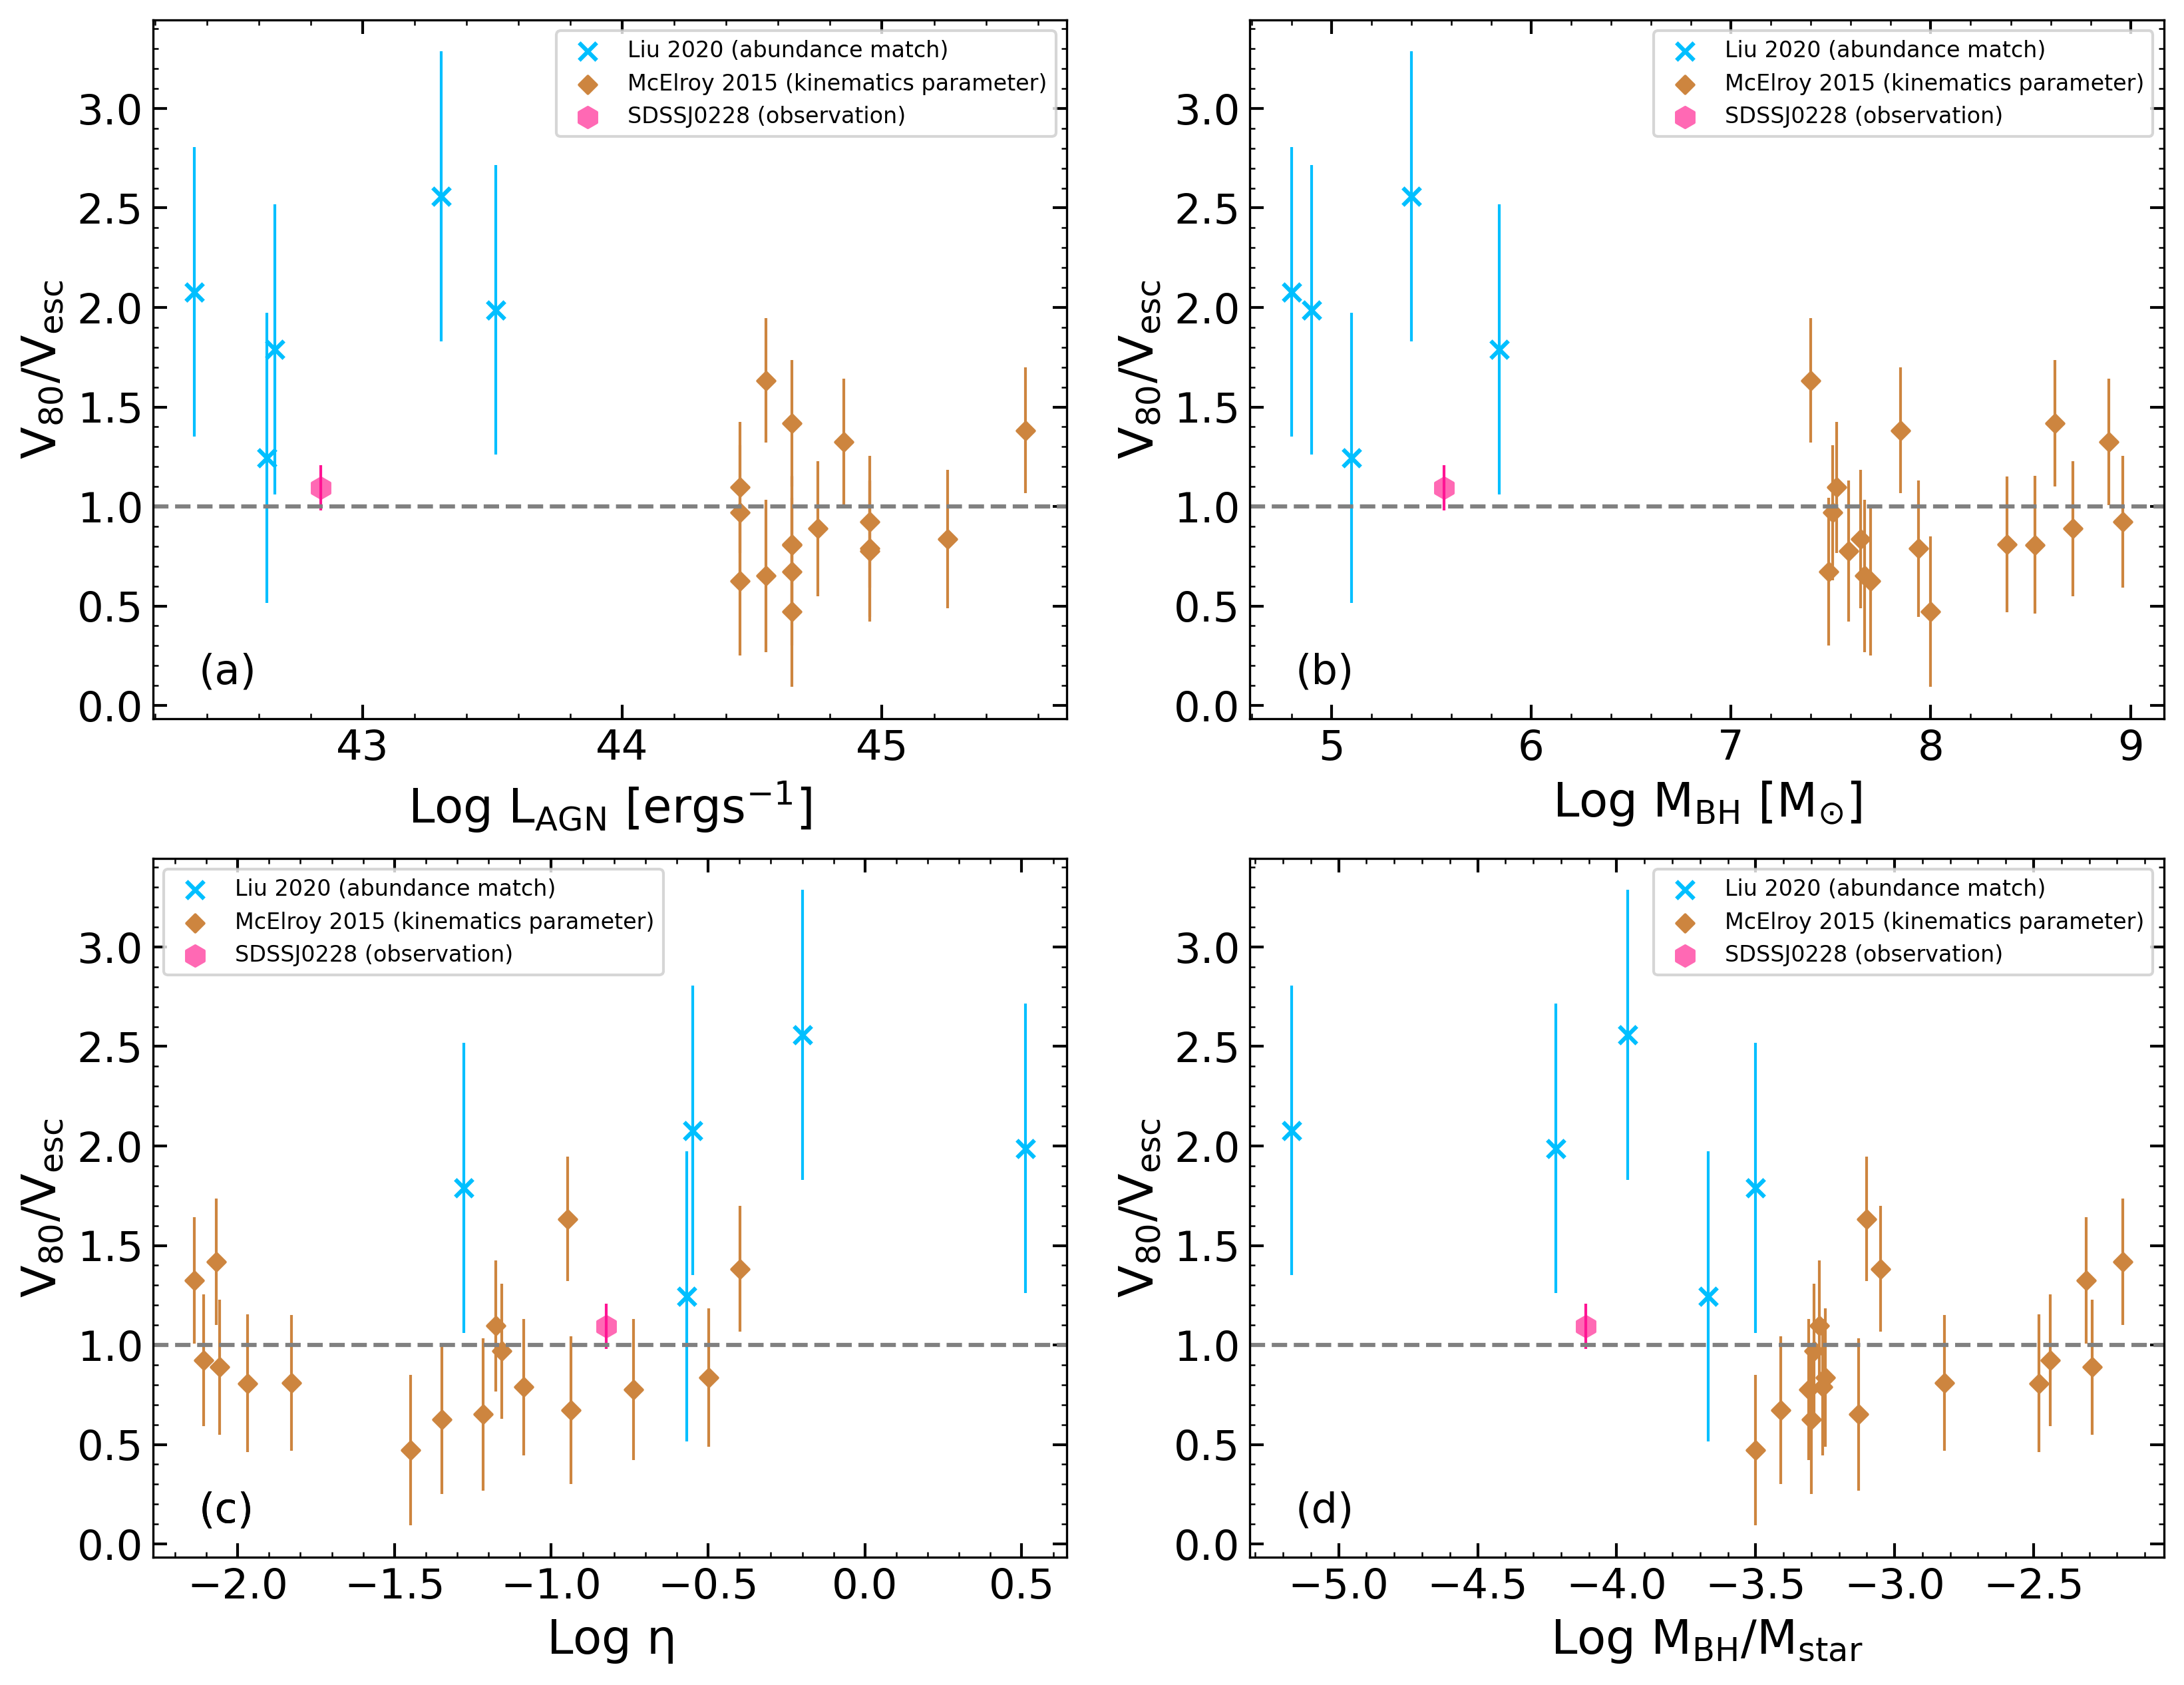

In [208]:
## fig-max-vel
fig = plt.figure(figsize=(13, 10),dpi = 300)
cmap = plt.cm.get_cmap('bwr')
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

ax5 = fig.add_subplot(221)
ax5.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax5.set_xlabel(r'${\rm Log\ L_{AGN}\ [ergs^{-1}]}$',fontsize = 17)
ax5.set_ylabel(r'${\rm V_{80}/V_{esc}}$',fontsize = 17)
ax5.text(0.05,0.05,'(a)',transform=ax5.transAxes,fontdict={'size': '15', 'color': 'black'})

ax5.errorbar(log_LAGN_L20, F_V80_max_L20, yerr = F_V80_max_err_L20, capsize=0,elinewidth=1,ecolor = 'deepskyblue',fmt = 'None')
ax5.scatter( log_LAGN_L20, F_V80_max_L20, c='deepskyblue', marker='x',s = 40,label = 'Liu 2020 (abundance match)')
ax5.errorbar(log_LAGN_M15, F_V80_max_M15, yerr = F_V80_max_err_M15, capsize=0,elinewidth=1,ecolor = 'peru',fmt = 'None')
ax5.scatter( log_LAGN_M15, F_V80_max_M15, c='peru', marker='D',s = 20,label = 'McElroy 2015 (kinematics parameter)')
ax5.errorbar(log_LAGN, F_V80_max, yerr = F_V80_max_err, capsize=0,elinewidth=1,ecolor = 'deeppink')
ax5.scatter( log_LAGN, F_V80_max, c='hotpink', marker='h',s = 55,label = 'SDSSJ0228 (observation)')

plt.axhline(y=1,color='gray',linestyle='--')
plt.legend(loc='upper right', fontsize = 8,)

ax7 = fig.add_subplot(222)
ax7.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax7.set_xlabel(r'${\rm Log\ M_{BH}\ [M_{\odot}]}$',fontsize = 17)
ax7.set_ylabel(r'${\rm V_{80}/V_{esc}}$',fontsize = 17)
ax7.text(0.05,0.05,'(b)',transform=ax7.transAxes,fontdict={'size': '15', 'color': 'black'})

ax7.errorbar(log_Mbh_L20, F_V80_max_L20, yerr = F_V80_max_err_L20, capsize=0,elinewidth=1,ecolor = 'deepskyblue',fmt = 'None')
ax7.scatter( log_Mbh_L20, F_V80_max_L20,c='deepskyblue',marker='x',s = 40,label = 'Liu 2020 (abundance match)')
ax7.errorbar(log_Mbh_M15, F_V80_max_M15,yerr = F_V80_max_err_M15,capsize=0,elinewidth=1,ecolor = 'peru',fmt = 'None')
ax7.scatter( log_Mbh_M15, F_V80_max_M15,c='peru',marker='D',s = 20,label = 'McElroy 2015 (kinematics parameter)')
ax7.errorbar(log_Mbh, F_V80_max,yerr = F_V80_max_err,capsize=0,elinewidth=1,ecolor = 'deeppink')
ax7.scatter( log_Mbh, F_V80_max,c='hotpink',marker='h',s = 55,label = 'SDSSJ0228 (observation)')

plt.axhline(y=1,color='gray',linestyle='--')
plt.legend(loc='upper right', fontsize = 8,)


ax9 = fig.add_subplot(223)
ax9.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax9.set_xlabel(r'${\rm Log\ \eta}$',fontsize = 17)
ax9.set_ylabel(r'${\rm V_{80}/V_{esc}}$',fontsize = 17)
ax9.text(0.05,0.05,'(c)',transform=ax9.transAxes,fontdict={'size': '15', 'color': 'black'})

ax9.errorbar(logR_edd_L20, F_V80_max_L20, yerr = F_V80_max_err_L20, capsize=0,elinewidth=1,ecolor = 'deepskyblue',fmt = 'None')
ax9.scatter( logR_edd_L20, F_V80_max_L20, c='deepskyblue', marker='x',s = 40,label = 'Liu 2020 (abundance match)')
ax9.errorbar(logR_edd_M15, F_V80_max_M15, yerr = F_V80_max_err_M15, capsize=0,elinewidth=1,ecolor = 'peru',fmt = 'None')
ax9.scatter( logR_edd_M15, F_V80_max_M15, c='peru', marker='D',s = 20,label = 'McElroy 2015 (kinematics parameter)')
ax9.errorbar(logR_edd, F_V80_max, yerr = F_V80_max_err, capsize=0,elinewidth=1,ecolor = 'deeppink')
ax9.scatter( logR_edd, F_V80_max, c='hotpink', marker='h',s = 55,label = 'SDSSJ0228 (observation)')

plt.axhline(y=1,color='gray',linestyle='--')
plt.legend(loc='upper left', fontsize = 8,)


ax1 = fig.add_subplot(224)
ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax1.set_xlabel(r'${\rm Log\ M_{BH}/M_{star}}$',fontsize = 17)
ax1.set_ylabel(r'${\rm V_{80}/V_{esc}}$',fontsize = 17)
ax1.text(0.05,0.05,'(c)',transform=ax9.transAxes,fontdict={'size': '15', 'color': 'black'})

ax1.errorbar(logMbh_Mstar_L20, F_V80_max_L20, yerr = F_V80_max_err_L20, capsize=0,elinewidth=1,ecolor = 'deepskyblue',fmt = 'None')
ax1.scatter( logMbh_Mstar_L20, F_V80_max_L20, c='deepskyblue', marker='x',s = 40,label = 'Liu 2020 (abundance match)')
ax1.errorbar(logMbh_Mstar_M15, F_V80_max_M15, yerr = F_V80_max_err_M15, capsize=0,elinewidth=1,ecolor = 'peru',fmt = 'None')
ax1.scatter( logMbh_Mstar_M15, F_V80_max_M15, c='peru', marker='D',s = 20,label = 'McElroy 2015 (kinematics parameter)')
ax1.errorbar(logMbh_Mstar, F_V80_max, yerr = F_V80_max_err, capsize=0,elinewidth=1,ecolor = 'deeppink')
ax1.scatter( logMbh_Mstar, F_V80_max, c='hotpink', marker='h',s = 55,label = 'SDSSJ0228 (observation)')
ax1.text(0.05,0.05,'(d)',transform=ax1.transAxes,fontdict={'size': '15', 'color': 'black'})

plt.axhline(y=1,color='gray',linestyle='--')
plt.legend(loc='upper right', fontsize = 8)


plt.savefig('image/discussion_max.pdf',dpi = 600,bbox_inches='tight')

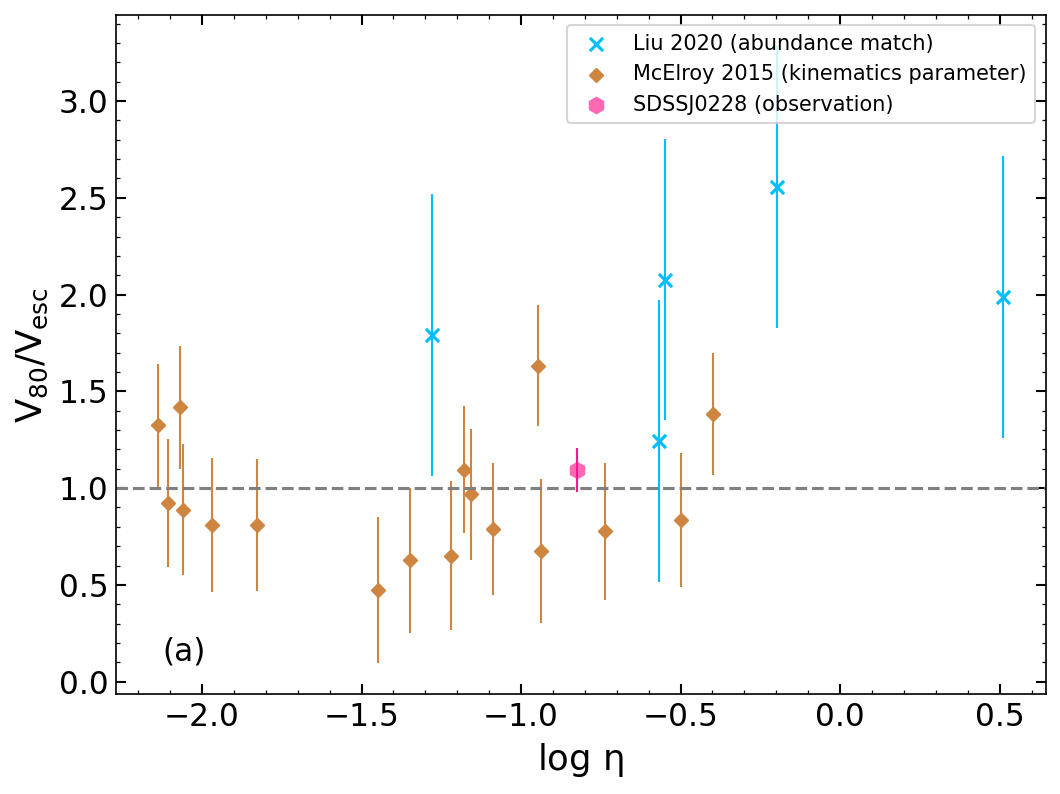

In [39]:
fig = plt.figure(figsize=(8, 6),dpi = 150)
cmap = plt.cm.get_cmap('bwr')
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

ax5 = fig.add_subplot(111)
ax5.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax5.set_xlabel(r'${\rm log\ \eta}$',fontsize = 17)
ax5.set_ylabel(r'${\rm V_{80}/V_{esc}}$',fontsize = 17)
ax5.text(0.05,0.05,'(a)',transform=ax5.transAxes,fontdict={'size': '15', 'color': 'black'})

ax5.errorbar(logR_edd_L20, F_V80_max_L20, yerr = F_V80_max_err_L20, capsize=0,elinewidth=1,ecolor = 'deepskyblue',fmt = 'None')
ax5.scatter( logR_edd_L20, F_V80_max_L20, c='deepskyblue', marker='x',s = 40,label = 'Liu 2020 (abundance match)')
ax5.errorbar(logR_edd_M15, F_V80_max_M15, yerr = F_V80_max_err_M15, capsize=0,elinewidth=1,ecolor = 'peru',fmt = 'None')
ax5.scatter( logR_edd_M15, F_V80_max_M15, c='peru', marker='D',s = 20,label = 'McElroy 2015 (kinematics parameter)')
ax5.errorbar(logR_edd, F_V80_max, yerr = F_V80_max_err, capsize=0,elinewidth=1,ecolor = 'deeppink')
ax5.scatter( logR_edd, F_V80_max, c='hotpink', marker='h',s = 55,label = 'SDSSJ0228 (observation)')

plt.axhline(y=1,color='gray',linestyle='--')
plt.legend(loc='upper right')

plt.savefig('image/fout_eddington_ratio.pdf',dpi = 600, bbox_inches='tight')